In [15]:

###################################
###################################
###################################
###################################

#PART 1: This part imports the already preprocessed data and builds a l
# logistic regression to pre-select variables that might be important 
# This is not the final model - but just a dimensionality reduction step to identify 
# variables that might be potentially interesting 


###################################
###################################
###################################
###################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("filtered_merged_variables.csv")

# -----------------------------
# 2. Create binary outcome: top 25% depression score = 1
# -----------------------------
cutoff = df['3_yr_depress_score'].quantile(0.75)
df['depressed'] = (df['3_yr_depress_score'] >= cutoff).astype(int)

# -----------------------------
# 3. Feature selection
# -----------------------------
X = df.drop(columns=['3_yr_depress_score', 'depressed'])
X = X.select_dtypes(include=[np.number])
X = X.fillna(X.mean())

y = df['depressed']

# -----------------------------
# 4. Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 5. Standardize features
# -----------------------------
X_mean = X_train.mean()
X_std = X_train.std()

X_train_std = (X_train - X_mean) / X_std
X_test_std = (X_test - X_mean) / X_std

# Add intercept
X_train_std.insert(0, 'intercept', 1)
X_test_std.insert(0, 'intercept', 1)

# Convert to NumPy
X_train_np = X_train_std.values
X_test_np = X_test_std.values
y_train_np = y_train.values
y_test_np = y_test.values

# -----------------------------
# 6. Manual logistic regression
# -----------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, weights):
    z = np.dot(X, weights)
    h = sigmoid(z)
    epsilon = 1e-5
    return -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

def gradient_descent(X, y, lr=0.01, n_iter=5000):
    weights = np.zeros(X.shape[1])
    for _ in range(n_iter):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient
    return weights

weights = gradient_descent(X_train_np, y_train_np)

# -----------------------------
# 7. Predictions and evaluation 
# -----------------------------
y_pred_proba = sigmoid(np.dot(X_test_np, weights))
y_pred = (y_pred_proba >= 0.5).astype(int)

# Intercept and coefficients
#print("Intercept:", weights[0])
#print("\nTop coefficients (non-zero):")
#for name, coef in zip(X_train_std.columns, weights):
    #if abs(coef) > 1e-4:
        #print(f"{name}: {coef:.4f}")

# Confusion matrix components
TP = np.sum((y_test_np == 1) & (y_pred == 1))
TN = np.sum((y_test_np == 0) & (y_pred == 0))
FP = np.sum((y_test_np == 0) & (y_pred == 1))
FN = np.sum((y_test_np == 1) & (y_pred == 0))

# Metrics
accuracy = (TP + TN) / len(y_test_np)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# ROC AUC (using rank ordering and trapezoidal integration)
def manual_auc(y_true, y_scores):
    # Sort by predicted probabilities
    desc_order = np.argsort(-y_scores)
    y_true_sorted = y_true[desc_order]
    
    TPR = [0]
    FPR = [0]
    P = np.sum(y_true)
    N = len(y_true) - P
    tp = 0
    fp = 0
    
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        TPR.append(tp / P if P else 0)
        FPR.append(fp / N if N else 0)
    
    auc = np.trapz(TPR, FPR)
    return auc

auc = manual_auc(y_test_np, y_pred_proba)

# Print results
print("\nMetrics (manual):")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {auc:.3f}")
print("\nConfusion Matrix:")
print(f"[[TN={TN} FP={FP}]\n [FN={FN} TP={TP}]]")

/var/folders/jw/1d1h57tx3vz7q9ymhn40qbn40000gn/T/ipykernel_11730/1087490697.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_std.insert(0, 'intercept', 1)
/var/folders/jw/1d1h57tx3vz7q9ymhn40qbn40000gn/T/ipykernel_11730/1087490697.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_std.insert(0, 'intercept', 1)



Metrics (manual):
Accuracy: 0.720
Precision: 0.631
Recall: 0.482
F1 Score: 0.547
ROC AUC: 0.754

Confusion Matrix:
[[TN=1113 FP=199]
 [FN=366 TP=341]]


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------------------
# 1. Load data and compute binary label
# ----------------------------------------
df = pd.read_csv("filtered_merged_variables.csv")
cutoff = df['3_yr_depress_score'].quantile(0.75)
df['depressed'] = (df['3_yr_depress_score'] >= cutoff).astype(int)

X = df.select_dtypes(include=[np.number]).drop(columns=['3_yr_depress_score', 'depressed'])
X = X.fillna(X.mean())
y = df['depressed']

# ----------------------------------------
# 2. Define only top features that are binary or 3-/5-point scale
# ----------------------------------------
filtered_top_features = [
    'cbcl_q24_p',
    'sleepdisturb4_p',
    'cbcl_q76_p',
    'cbcl_q102_p',
    'cbcl_q01_p',
    'cbcl_q61_p',
    'famhx_ss_parent_prf_p',
    'kbi_p_conflict',
    'ksads_asd_raw_560_p',
    'asr_q120_p',
    'asr_q116_p',
    'sai_ss_basket_nyr_p'
]

# ----------------------------------------
# 3. Subset X and split
# ----------------------------------------
X_top = X[filtered_top_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, stratify=y, random_state=2
)

# ----------------------------------------
# 4. Standardize and add intercept
# ----------------------------------------
X_mean = X_train.mean()
X_std = X_train.std()
X_train_std = (X_train - X_mean) / X_std
X_test_std = (X_test - X_mean) / X_std

X_train_std.insert(0, 'intercept', 1)
X_test_std.insert(0, 'intercept', 1)

X_train_np = X_train_std.values
X_test_np = X_test_std.values
y_train_np = y_train.values
y_test_np = y_test.values

# ----------------------------------------
# 5. Manual logistic regression
# ----------------------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient_descent(X, y, lr=0.01, n_iter=1000):
    weights = np.zeros(X.shape[1])
    for _ in range(n_iter):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient
    return weights

weights = gradient_descent(X_train_np, y_train_np)

# ----------------------------------------
# 6. Predict and evaluate (threshold = 0.25)
# ----------------------------------------
y_pred_proba = sigmoid(np.dot(X_test_np, weights))
y_pred = (y_pred_proba >= 0.25).astype(int)

intercept = weights[0]
coefs = weights[1:]

print(f"\nIntercept: {intercept:.4f}")
print("\nFiltered Feature Coefficients:")
for name, coef in zip(filtered_top_features, coefs):
    print(f"{name}: {coef:.4f}")

# ----------------------------------------
# 7. Manual metrics
# ----------------------------------------
TP = np.sum((y_test_np == 1) & (y_pred == 1))
TN = np.sum((y_test_np == 0) & (y_pred == 0))
FP = np.sum((y_test_np == 0) & (y_pred == 1))
FN = np.sum((y_test_np == 1) & (y_pred == 0))

accuracy = (TP + TN) / len(y_test_np)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nEvaluation:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Confusion Matrix:\n[[TN={TN} FP={FP}]\n [FN={FN} TP={TP}]]")

# ----------------------------------------
# 8. Final equation
# ----------------------------------------
print("\nLogistic Regression Equation:")
equation = f"logit(p) = {intercept:.4f}"
for name, coef in zip(filtered_top_features, coefs):
    sign = "+" if coef >= 0 else "-"
    equation += f" {sign} {abs(coef):.4f} * {name}"
print(equation)


Intercept: -0.5833

Filtered Feature Coefficients:
cbcl_q24_p: 0.2902
sleepdisturb4_p: 0.3003
cbcl_q76_p: 0.1844
cbcl_q102_p: 0.2228
cbcl_q01_p: 0.1467
cbcl_q61_p: 0.0356
famhx_ss_parent_prf_p: 0.1889
kbi_p_conflict: 0.1825
ksads_asd_raw_560_p: 0.1438
asr_q120_p: 0.1244
asr_q116_p: 0.1827
sai_ss_basket_nyr_p: -0.1044

Evaluation:
Accuracy: 0.586
Precision: 0.452
Recall: 0.850
F1 Score: 0.590
Confusion Matrix:
[[TN=582 FP=730]
 [FN=106 TP=601]]

Logistic Regression Equation:
logit(p) = -0.5833 + 0.2902 * cbcl_q24_p + 0.3003 * sleepdisturb4_p + 0.1844 * cbcl_q76_p + 0.2228 * cbcl_q102_p + 0.1467 * cbcl_q01_p + 0.0356 * cbcl_q61_p + 0.1889 * famhx_ss_parent_prf_p + 0.1825 * kbi_p_conflict + 0.1438 * ksads_asd_raw_560_p + 0.1244 * asr_q120_p + 0.1827 * asr_q116_p - 0.1044 * sai_ss_basket_nyr_p


Accuracy: 0.586
Precision: 0.452
Recall: 0.85
F1 Score: 0.59
Confusion Matrix:
[[582 730]
 [106 601]]


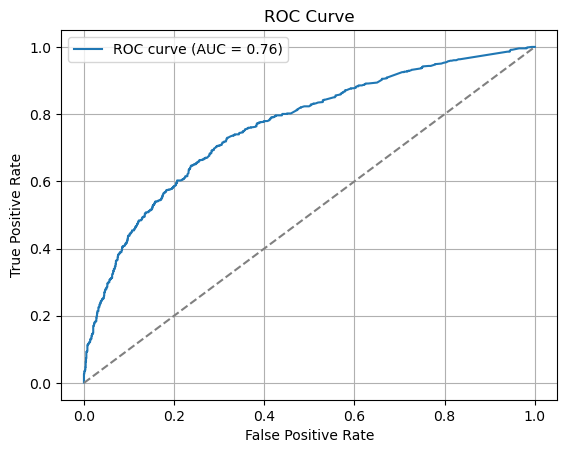

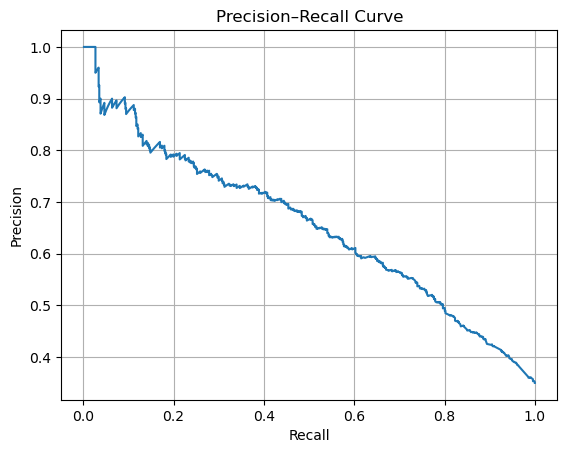

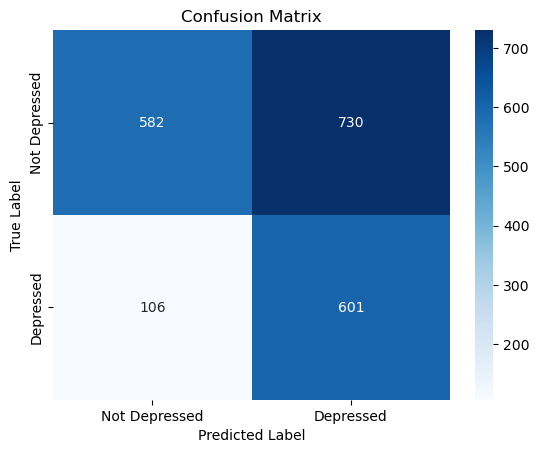

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 8. Manual Evaluation
# -----------------------------
# Confusion matrix components
TP = np.sum((y_test_np == 1) & (y_pred == 1))
TN = np.sum((y_test_np == 0) & (y_pred == 0))
FP = np.sum((y_test_np == 0) & (y_pred == 1))
FN = np.sum((y_test_np == 1) & (y_pred == 0))

accuracy = (TP + TN) / len(y_test_np)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Print metrics
print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))
print("Confusion Matrix:")
print(np.array([[TN, FP], [FN, TP]]))

# -----------------------------
# ROC Curve (manual)
# -----------------------------
def compute_roc(y_true, y_scores):
    thresholds = np.unique(y_scores)[::-1]
    tpr_list = []
    fpr_list = []

    P = np.sum(y_true)
    N = len(y_true) - P

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TPR = TP / P if P else 0
        FPR = FP / N if N else 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)

    return np.array(fpr_list), np.array(tpr_list)

def compute_auc(x, y):
    return np.trapz(y, x)

fpr, tpr = compute_roc(y_test_np, y_pred_proba)
roc_auc = compute_auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Precision-Recall Curve
# -----------------------------
def compute_pr(y_true, y_scores):
    thresholds = np.unique(y_scores)[::-1]
    precision_list = []
    recall_list = []

    P = np.sum(y_true)

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / P if P else 0

        precision_list.append(prec)
        recall_list.append(rec)

    return np.array(recall_list), np.array(precision_list)

recall_vals, precision_vals = compute_pr(y_test_np, y_pred_proba)

plt.figure()
plt.plot(recall_vals, precision_vals, label="Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

# -----------------------------
# Confusion Matrix Heatmap
# -----------------------------
conf_matrix = np.array([[TN, FP], [FN, TP]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Depressed', 'Depressed'],
            yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()